In [1]:
import numpy as np
from PIL import Image
import os
import sys
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "..",".."))

# Add the parent directory to sys.path
sys.path.append(parent_dir)

# Verify if the parent directory is added
print("Parent directory added to sys.path:", parent_dir)


from awesome.model.path_connected_net import PathConnectedNet
from awesome.util.path_tools import get_project_root_path
from awesome.run.functions import plot_as_image, get_mpl_figure, plot_mask
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.auto import tqdm
from awesome.model.convex_net import ConvexNextNet
from awesome.model.net_factory import get_norm, init_realnvp
from awesome.model.norm_net import NormNet
from awesome.model.pixelize_net import PixelizeNet
from torch.nn import BCEWithLogitsLoss
from awesome.run.runner import seed_all
from matplotlib.colors import get_named_colors_mapping
from awesome.util.torch import tensorify

from awesome.model.zoo import Zoo
zoo = Zoo()

import matplotlib.pyplot as plt
%matplotlib inline

plt.ioff()



Parent directory added to sys.path: /Users/kenjileong/Documents/GitHub/awesome


/opt/anaconda3/envs/smu_opt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# How-To: Path-Connectedness

This is a simple demonstration, how to use our path-connectedness prior to get a path connected segmentation of some unaries.
We used the "sequential" fit as terminology in our manuscript, one can also discribe it as post-processing to some initial segmentation.


Lets consider the following example:

One tries to get a path-connected segmentation of the cat, and the image was scribbled with some foreground scribbles.

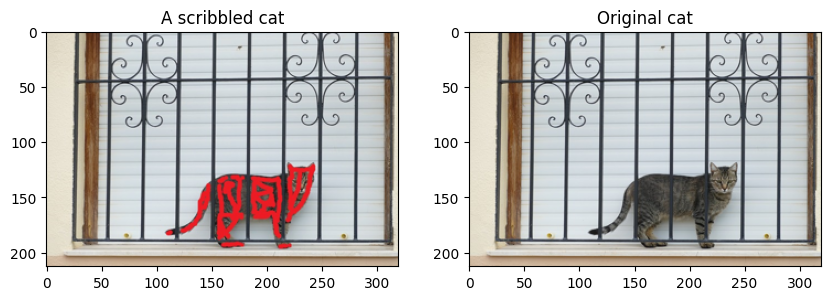

In [2]:
img_dir="data/cat_scribbled.jpg"
img_orig_dir="data/cat.jpg"

def load_image(path: str, down_scale: int = 1) -> np.ndarray:
    img_pil=Image.open(path)
    width, height = img_pil.size 
    newsize = (int(width/down_scale), int(height/down_scale))
    img_pil = img_pil.resize(newsize)

    img= np.array(img_pil, dtype='float')/255.0
    img = img[:,:,0:3]
    nx,ny,nc = img.shape
    return img

img = load_image(img_dir, down_scale=2)
img_orig = load_image(img_orig_dir, down_scale=2)

fig, axes = get_mpl_figure(1, 2, ratio_or_img=img)
plot_as_image(img, variable_name="A scribbled cat", axes=axes[0])
plot_as_image(img_orig, variable_name="Original cat", axes=axes[1])

fig

First, lets try to get the scribble from the image to use them as unaries.

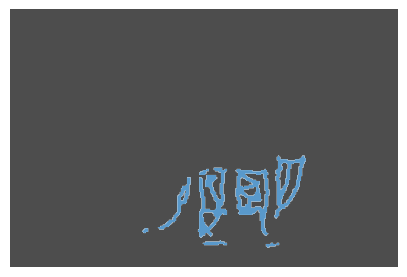

In [3]:
likelihood = torch.tensor((img[:,:,0]-img[:,:,1])>0.7).float()
fig = plot_mask(None, likelihood, filled_contours=True, lined_contours=False)
fig

Then, we will use the path-connectedness prior to get a path-connected segmentation of the cat.
Lets init the model for this first.

In [4]:

use_cuda = False
# Use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() and use_cuda else "cpu")

height, width = likelihood.shape[-2:]

def get_model_device(model):
    return next(model.parameters()).device

# We need a coordinate grid, which we use to query our implicit representation.
def create_grid(image_shape, device: torch.device):
    ny, nx = image_shape
    x = torch.arange(0, nx, device=device)
    y = torch.arange(0, ny, device=device)
    xx, yy = torch.meshgrid(x, y, indexing='xy')
    grid = torch.stack((xx, yy), dim=0)
    batched_input = grid.unsqueeze(0).float() / torch.tensor([nx, ny], device=device).float().unsqueeze(-1).unsqueeze(-1)
    return batched_input

# We define the FG as 0, so we need to invert the mask
unaries = 1 - likelihood.to(device)

seed_all(0)

# We use a factory function here to generate some Normalizing Flows, which we use to model the diffeomorphism.
flow_net = init_realnvp(
                        channels=2, 
                        n_flows=10,
                        height=height, 
                        width=width,
                        output_fn="tanh"
                        )

# The realnvp takes in a 2d input (B, C, H, W), while the convex net takes in a 1d input (B*H*W, C).
# To accompansate, we use the PixelizeNet to flatten the input.
flow = PixelizeNet(flow_net)


norm = get_norm("minmax", dim=(0, 2, 3)) # Channel wise normalization
norm.fit(create_grid(unaries.shape[-2:], device=torch.device("cpu")))
norm_flow = NormNet(net=flow, norm=norm)

model = PathConnectedNet(convex_net=ConvexNextNet(n_hidden_layers=2), flow_net=norm_flow)
model.to(device)

# Before learning the Diffeo and Convex in Path connected net, it is usally helpful to learn the flow identity first. This will give the convex net some time to adjust.
# We using a simple model zoo, so we dont have to train the flow identity from scratch if its trained once with a destinct parameter set.
x = create_grid(unaries.shape[-2:], unaries.device)
model.learn_flow_identity(x, zoo=zoo)

# To accompensate for potential exploding weights, we use weight decay on the flow net.
groups = []
groups.append(dict(params=model.flow_net.parameters(), weight_decay=1e-5, lr=2e-3))
groups.append(dict(params=model.convex_net.parameters()))
groups.append(dict(params=model.linear.parameters()))

def plot_loss(loss: torch.Tensor):
    fig, ax = get_mpl_figure(1, 1)
    ax.plot(loss.detach().cpu().numpy())
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Training Loss")
    return fig

# Using Adamax as optimizer for the flow net was giving us slightly better results than Adam, but feel free to experiment.
optimizer = torch.optim.Adamax(groups, lr=1e-3)  
num_epochs = 100



Learning flow identity: 100%|██████████| 1000/1000 [01:51<00:00,  9.01it/s, loss=2.883e-08]


Now we can fit the model to the data. This will take a while, so we will only train for 2000 epochs.

Training: 100%|██████████| 100/100 [00:24<00:00,  4.15it/s, loss=0.4] 


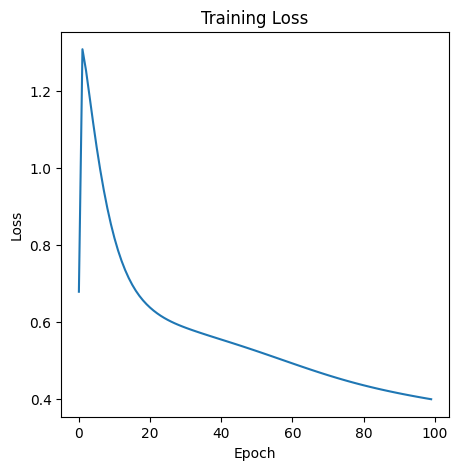

In [5]:

def train(
        optimizer: torch.optim.Optimizer, 
        model: PathConnectedNet, 
        unaries: torch.Tensor, 
        num_epochs: int, 
        fg_weight: float = 0.66,
        ):
    # Train the model
    loss_full = torch.zeros(num_epochs, dtype=torch.float32, device=unaries.device)
    model.train()


    criterion = BCEWithLogitsLoss(reduction='none')

    batched_input = create_grid(unaries.shape[-2:], unaries.device)
    it = tqdm(range(num_epochs), total=num_epochs, desc=f"Training")
    batched_unaries = unaries.unsqueeze(0).unsqueeze(0)

    background_mask = batched_unaries == 1.
    foreground_mask = ~background_mask

    bg_length = background_mask.sum()
    fg_length = foreground_mask.sum()

    fg_weight = tensorify(fg_weight, device=unaries.device)

    for epoch in it:
        
        out = model(batched_input)
        if torch.isnan(out).any():
            raise ValueError("Output is nan")

        fg_loss = criterion(out[foreground_mask], batched_unaries[foreground_mask])
        bg_loss = criterion(out[background_mask], batched_unaries[background_mask])

        # As we take a BCE loss, we must adjust the weighting to account for the log => 0 problem.
        # Other loss functions might not need this adjustment. 
        loss = ((((1 - fg_weight) * (bg_loss)).sum() / bg_length) + ((fg_weight * fg_loss).sum() / fg_length))

        loss_full[epoch] = loss.detach().cpu()
            
        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # After Each epoch we enforce the convexity of the convex net to ensure the convexity of the model => Weights should be positive
        model.enforce_convexity()

        if (epoch+1) % 50 == 0 or epoch == 0:
            it.set_postfix({'loss': loss.item()})
            
    return model, loss_full

tm, loss = train(optimizer, model, unaries, num_epochs, fg_weight=0.3)
fig = plot_loss(loss)
fig

With the trained model, we can now inference the segmentation of the cat.

In [6]:
model.eval()
with torch.no_grad():
    # We query the model with a grid of coordinates. The model will return the likelihood of each pixel being foreground.
    # We can also create a super resolution grid to get a higher resolution output.
    in_ = create_grid(unaries.shape[-2:], unaries.device).to(get_model_device(model))
    path_connected_likelihood = model(in_).squeeze().cpu()

# We can now threshold the output to get a binary mask.
path_connected_likelihood_mask = torch.sigmoid(path_connected_likelihood) < 0.5

## Voila! We have a path-connected segmentation of the cat.

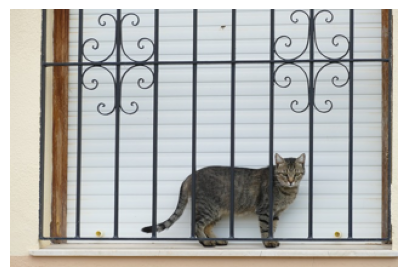

In [7]:
color = get_named_colors_mapping().get("tab:orange")
plot_mask(img_orig, path_connected_likelihood_mask, color=color, variable_name="Output of the model")